In [1]:
#Connect to drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [202]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split 
import seaborn as sns

In [226]:
#Import dataset
data = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/csv_files/cal-housing.csv")

In [191]:
print(data.shape)

(20640, 10)


In [199]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [228]:
categ = data["ocean_proximity"]
num = data.copy()
del num["ocean_proximity"]

In [227]:
fig = plt.figure(figsize =(20,10))
for i, column in enumerate(num.columns, 1):
  plt.subplot(3,3,i)
  sns.distplot(num[column])
sns.boxplot(data=data["median_house_value"])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

Error in callback <function flush_figures at 0x7fae349083b0> (for post_execute):


KeyboardInterrupt: ignored

In [ ]:
sns.pairplot(data, hue="ocean_proximity", palette="crest")

In [229]:
#Delete outliers in median_house_price
data = data.loc[data["median_house_value"]<500001,:]

In [230]:
data["ocean_proximity"].value_counts()

<1H OCEAN     8604
INLAND        6524
NEAR OCEAN    2446
NEAR BAY      2096
ISLAND           5
Name: ocean_proximity, dtype: int64

[]

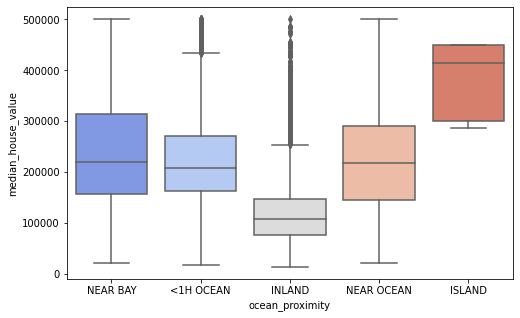

In [209]:
#boxplot of house value on ocean_proximity categories
plt.figure(figsize=(8,5))
sns.boxplot(x="ocean_proximity",y="median_house_value",data=data, palette="coolwarm")
plt.plot()

In [231]:
#Create dummies for categorical
data= pd.concat([pd.get_dummies(data["ocean_proximity"], drop_first=True),data],axis=1).drop("ocean_proximity",axis=1)

In [232]:
#Drop Nan values
data = data.dropna()
data.isna().sum()

INLAND                0
ISLAND                0
NEAR BAY              0
NEAR OCEAN            0
longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
dtype: int64

In [ ]:
#Define correlation matrix
corr= data.corr()
corr_matrix=corr[((corr>0.75) | (corr < -0.75)) & (corr != 1.0)]
corr_matrix

In [233]:
del data["households"]

In [234]:
del data["total_bedrooms"]

In [ ]:
#Normalization
def normalize_dataset(dataset):
    f = dataset.apply(lambda x: (x-min(x))/(max(x)-min(x)))
    return f

In [67]:
#Standardization
def standardized_dataset(dataset):
     m = dataset.apply(lambda x: ((x-np.mean(x))/np.std(x)))
     return m

In [68]:
X = standardized_dataset(data)

In [69]:
#Separate independent and dependent variables to run regression
Y = pd.DataFrame(X["median_house_value"])
del X["median_house_value"]

In [70]:
#Define ridge regression
def Ridge_regression(X,Y,alpha):
  m = X.shape[0]
  Trans_X=np.transpose(X)
  X_Trans_X=np.dot(Trans_X, X)
  Ident_M=np.identity(X.shape[1])
  ridge=np.linalg.inv(X_Trans_X+(alpha*Ident_M*m))
  t=np.dot(ridge,np.dot(Trans_X,Y))
  return t
#Pred ridge regression
def Ridge_pred(X,w):
  pred =(np.dot(X,w))
  return pred

In [71]:
def error(w, x_train, y_train):
    y = Ridge_pred(x_train,w)
    s = np.average(np.square(np.subtract(y, y_train)))
    return s

In [72]:
#Cross validation
def cross_val(x_train, y_train, k, alpha):
     a = np.column_stack((x_train, y_train))
     a = np.random.permutation(a)               
     cv_error = np.zeros(k)
    
     for i, f in enumerate(np.split(a, k)):   
         x_train, y_train = f[:, :-1], f[:, -1]
         if i != len(np.split(a, k)) -1:
          x_test, y_test = f[:, :-1], f[:, -1]
         w = Ridge_regression(x_train, y_train, alpha)
  
         cv_error[i] = error(w, x_test, y_test)   
     return np.average(cv_error) 

In [73]:
def results(alphas, cv_error):
    res = np.round(np.column_stack((alphas, cv_error)), 3)
    df = pd.DataFrame(res, columns=['alpha', 'cv error'])
    print(df)

In [74]:
def plot_cv_curve(alphas, cv_error):
    d = plt.plot(alphas, cv_error, color="blue")
    plt.xlabel("alpha")
    plt.ylabel("cv error")
    print(d)

In [187]:
def det_alpha(x_train, y_train):
    alphas = np.linspace(0,1,150)
    cv_error = np.zeros_like(alphas)

    for i, a in enumerate(alphas):
        cv_error[i] = cross_val(x_train, y_train,5, a)  
    results(alphas, cv_error)
    
    return results, plot_cv_curve(alphas, cv_error) #alphas[np.argmin(cv_error)]

   alpha  cv error
0  0.007     0.369
1  0.009     0.369
2  0.011     0.365
3  0.013     0.371


(<function __main__.results>, None)

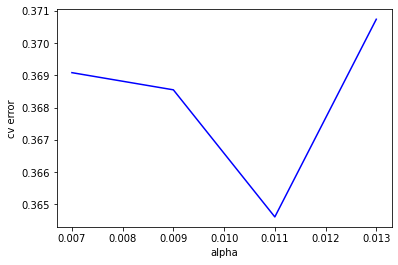

In [236]:
det_alpha(X,Y) 


In [ ]:
#Applying PCA
columns = ["INLAND", "ISLAND", "NEAR_BAY","NEAR_OCEAN"]
X.drop(columns, axis=1, inplace=True)

In [20]:
def PCA(X):
  a = X - np.mean(X)
  cov_M  = a.T @ a / (X.shape[0] - 1)  
  cov_M = X.T @ X / (X.shape[0] - 1)
  cov_M = np.array(cov_M, dtype=float)
  eigen_vals, eigen_vecs = np.linalg.eig(cov_M)  
  eigen_vals_total = np.sum(eigen_vals)            
  variance_exp = eigen_vals / eigen_vals_total
  cum_var_exp = np.cumsum(variance_exp)
  eigen_vecs = pd.DataFrame(eigen_vecs)  
  project_matrix = result = np.dot(X,eigen_vecs) 
  project_matrix = pd.DataFrame(project_matrix)
  project_matrix = project_matrix.rename(columns={0:"PC1", 1: "PC2",2:"PC3", 3: "PC4", 4:"PC5", 5: "PC6",6:"PC7", 7: "PC8",8: "PC9"})
  project_matrix
  return variance_exp, cum_var_exp, project_matrix

In [ ]:
pca = PCA(X)

In [ ]:
results1= pd.DataFrame(pca[0], columns= ["Variance Explained"])
results = results1.T
results = results.rename(columns={0:"PC1", 1: "PC2",2:"PC3", 3: "PC4", 4:"PC5", 5: "PC6",6:"PC7", 7: "PC8",8: "PC9"})
results

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
Variance Explained,0.433981,0.224669,0.119572,0.103985,0.085317,0.016487,0.008839,0.005,0.002149


In [ ]:
results2= pd.DataFrame(pca[1], columns= ["Cumulative Explained Variance"])
resultsb = results2.T
resultsb = resultsb.rename(columns={0:"PC1", 1: "PC2",2:"PC3", 3: "PC4", 4:"PC5", 5: "PC6",6:"PC7", 7: "PC8",8: "PC9"})
resultsb

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
Cumulative Explained Variance,0.433981,0.658651,0.778223,0.882208,0.967525,0.984012,0.992851,0.997851,1.0


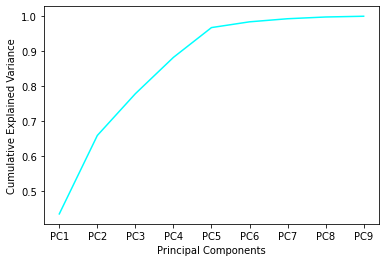

In [ ]:
#plot cumulative variance for PCs
plt.plot(resultsb.T, color="aqua")
plt.xlabel('Principal Components')
plt.ylabel('Cumulative Explained Variance');

In [ ]:
#Select first two components to run the ridge on them
PC = pca[2].iloc[:, 0:2]

   alpha  cv error
0    0.2     0.487
1    0.4     0.508
2    0.6     0.547
3    0.8     0.577


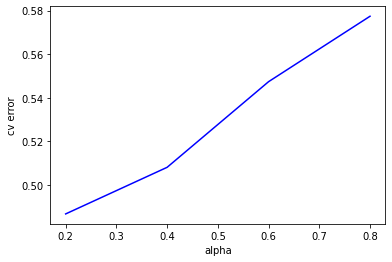

In [ ]:
det_alpha(PC,Y)